### <div align="center">***CLASIFICACION DE CITOLOGIAS***</div>
***
Clasificador automatico de imágenes de citologías cervicovaginales al microscopio óptico mediante redes neuronales (modelo supervisado).


##### **IMPORT LIBRARIES AND UTILS** 

In [ ]:
from utils import IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS, BATCH_SIZE, EPOCHS, DATA_PATH, balanceData,  loadImage 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os
                    
from skimage.io import imread 
import cv2                    

from sklearn.model_selection import train_test_split    # Para el split de los datos del modelo
from sklearn.utils import shuffle                       # Para mezclar las muestras y evitar sesgos
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

##### **TRAINING**

In [ ]:
# CREAMOS UN DATAFRAME CON LOS ARCHIVOS DE IMAGEN

file_list = os.listdir(DATA_PATH)
df_cito = pd.DataFrame()
category = [0 if 'normal' in file else 1 for file in file_list] 
df_cito['file_name'] = file_list  # Columna con los nombres de los archivos
df_cito['category'] = category    # Columna con la categoría de los archivos: 0 celulas normales ; 1 celulas atipicas.
df_cito

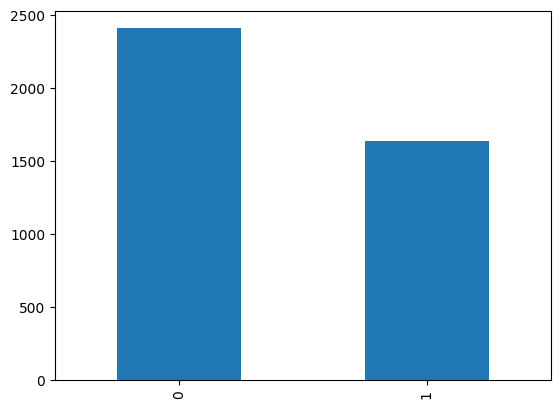

In [7]:
df_cito['categoria'].value_counts().plot.bar(); # Comprobamos que balance de imágenes en las categorias

files = balanceData(DATA_PATH) # Balanceamos las categorias.

##### **LOAD DATA**

Usamos la funcion loadImage() para estandarizar las dimensiones de las imagenes y ajustarlas todas a las misma resolución, es decir hacerles un resize.  

Decidimos cargarlas en color porque el scoring del modelo mejoraba considerablemente si no reducimos los features en escala de grises (probamos previamente ambos).

El split de los grupos para el entrenamiento del modelo lo determinamos de la siguiente manera:

- **Train:**  ```len(df_cito['category']==0) * 2 * 0.8```  

- **Test:**  ```len(df_cito['category']==0) * 2 * 0.2```

In [34]:
X,Y = loadImage(DATA_PATH, IMAGE_HEIGHT, IMAGE_WIDTH) # Almacenamos las imagenes procesadas, con el resize aplicado.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size= 0.8, random_state=14, shuffle=True, stratify=Y) # Split subsets de train-test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3679, 350, 350)
(370, 350, 350)
(3679,)
(370,)


##### **NORMALIZACION**

In [ ]:
pd.DataFrame(y_train).value_counts(normalize=True)

In [ ]:
pd.DataFrame(y_test).value_counts(normalize=True)

In [41]:
X_train = X_train/255.0
X_test = X_test/255.0

print('Min:',np.min(X_train))
print('Max:',np.max(X_train))

Min: 0.0004720822839567202
Max: 0.00392156862745098


##### **MEZCLA DATOS**

In [45]:
X_train, y_train = shuffle(X_train, y_train, random_state=42) # lo obviamos si lo hemos hecho en la funcion de split

##### **GUARDAR/CARGAR DATOS**

In [152]:
# np.savez('data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [153]:
# data = np.load('data.npz')

X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

##### **MODELO**

In [154]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation

model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu',
                input_shape=(ANCHURA_IMAGEN, ALTURA_IMAGEN, CHANNELS_IMAGEN)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

'''
También podríamos haber usado dos neuronas de salida.
Para ello hay que pasar la "y" a one-hot-encoding usando 

from keras.utils import to_categorical
y_train = to_categorical(y_train)

La capa de salida sería:
model.add(Dense(2, activation='softmax'))

Si tuviera 3 o más clases tendría que usar esta opción
'''

model.compile(optimizer='adam', loss='binary_crossentropy',
             metrics=['accuracy'])

##### **FIT** (Entrenamiento)

In [ ]:
history = model.fit(X_train,y_train,epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
                   validation_split=0.2)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

##### **EVALUACION** 

In [ ]:
results = model.evaluate(X_test,y_test)
print("test loss, test accuracy", results)

In [ ]:
model.predict(X_test[0])